In [1]:
using LinearAlgebra;
using SparseArrays;
BLAS.get_config()

LinearAlgebra.BLAS.LBTConfig
Libraries: 
└ [ILP64] libopenblas64_.dll

In [2]:
function laplacien(N)
    N² = N*N;
    # BLOC EXTRA-DIAGONAL
    J = -1.0*I(N)
    
    # BLOC DIAGONAL
    diag = 4*ones(Float64,N);  # vecteur de la diagonale
    extra_diag = -1.0*ones(Float64,N-1); # vecteur de la sur- et sous-diagonale remplies de 1
    T = SymTridiagonal(diag, extra_diag);  # matrice des blocs diagonaux, qui est tridiagonale symétrique

    # assemblage du laplacien
    Λ = spzeros(N²,N²);
    @views for i in 1:N
        Λ[1+(i-1)*N:i*N,1+(i-1)*N:i*N] .= T[:,:]
    end
    
    @views for i in 1:N-1
        Λ[1+(i-1)* N : i    *N, 1+(i)  *N :  (i+1)*N] .= J[:,:] # remplissage blocs extradiag supérieurs
        Λ[1+(i)  * N : (i+1)*N, 1+(i-1)*N :      i*N] .= J[:,:] # remplissage blocs extradiag inférieurs
    end
    return Hermitian(Λ)
end

laplacien (generic function with 1 method)

# Quelques tests de performance
#### Comparaison entre l'inversion d'un système et multiplication par la matrice inverse

In [13]:
using Distributions;
N = 2000
A = rand(Complex{Float64},(N,N));
@time Ainv = inv(A);

  0.555346 seconds (5 allocations: 63.004 MiB)


In [11]:
using BenchmarkTools;
x = rand(Complex{Float64},(N,1))
@time A\x;
# @btime $A \ $x;
# @btime $Ainv*$x;

  0.262120 seconds (5 allocations: 61.081 MiB)


Conclusion: si le système linéaire qu'on résout est toujours le même (avec le terme de droite qui change), il vaut mieux inverser la matrice une bonne fois pour toutes et multiplier par l'inverse ce qui est très rapide (c'était prévisible). Mais on perd en précision un ordre de grandeur. Ce [thread](https://discourse.julialang.org/t/solving-ax-b-for-large-matrix-dimesnions-efficiently-in-julia/51504/) suggère de plutôt résoudre un système et computation_grapher la décomposition de Choleski si on souhaite recommencer avec d'autres termes de droite

In [113]:
using LinearAlgebra;
norm(A*sls - x)
# on constate que la méthode par résolution de  système linéaire est plus gourmande en opérations mais moins précise d'un ordre de grandeur

6.386426029784002e-11

In [114]:
norm(A*mi - x)

3.5613829080181373e-10

#### Comparaison entre la multiplication matricielle par une Vandermonde du paquet `SpecialMAtrices`et la Fast Fourier Transform

In [53]:
using FFTW;
using BenchmarkTools;
N = 1000;

ψ = rand(Complex{Float64},(N));

In [54]:
using SpecialMatrices;
r = [exp(-k*im*pi/N) for k in 0:N-1];
V = Vandermonde(r);

In [58]:
@btime V*$ψ;

  20.744 ms (1 allocation: 15.75 KiB)


In [59]:
@btime fft($ψ);

  15.300 μs (26 allocations: 17.47 KiB)


### Comparaison entre OpenBLAS (librairie par défaut utilisée par `LinearAlgebra`) et `MKL`
####  OpenBLAS versus MKL pour l'inversion de matrices 
Conclusion: pour inverser des matrices petites tout du moins, MKL est un peu plus rapide
Voir les explications ici: [Runtime-switchable BLAS/LAPACK backends via libblastrampoline | E Saba, M Giordano | JuliaCon2021](https://www.youtube.com/watch?v=t6hptekOR7s)

In [6]:
using LinearAlgebra;
using BenchmarkTools;
BLAS.get_config()
BLAS.get_num_threads()

LinearAlgebra.BLAS.LBTConfig
Libraries: 
└ [ILP64] libopenblas64_.dll

In [12]:
N = 60;
R = rand(Complex{Float64},(N,N));
@btime inv($R);

  1.192 ms (5 allocations: 116.97 KiB)


In [13]:
using MKL;
using LinearAlgebra;
BLAS.get_config()

LinearAlgebra.BLAS.LBTConfig
Libraries: 
└ [ILP64] mkl_rt.2.dll

In [14]:
N = 60;
R = rand(Complex{Float64},(N,N));
@btime inv($R);

  83.700 μs (5 allocations: 116.97 KiB)


### Lapack versus BLAS pour l'inversion de matrices
Résultat: ce sont les mêmes performances

In [10]:
using LinearAlgebra.LAPACK
using BenchmarkTools;
R = rand(Complex{Float64},(100,100));
@btime inv($R);

  2.462 ms (5 allocations: 257.31 KiB)


In [9]:
using LinearAlgebra.BLAS
using BenchmarkTools;
R = rand(Complex{Float64},(100,100));
@btime inv($R);

  2.519 ms (5 allocations: 257.31 KiB)


## Comparer les différentes stratégies pour inverser la matrice hermitienne du laplacien

In [34]:
using SparseArrays
N = 1000;
ed = -1*ones(N-1);
di = 4*ones(N);
H_st = SymTridiagonal(di,ed);
H = Matrix{ComplexF64}(H_st);
H_h = Hermitian(H);
H_hst = Hermitian(H_st)
H_sp = sparse(H);
H_sym = Symmetric(H);
@show isposdef(H);
@show ishermitian(H);
@show typeof(H_hst);
@show typeof(H);
@show typeof(H_h);

isposdef(H) = true
ishermitian(H) = true
typeof(H_hst) = Hermitian{Float64, SymTridiagonal{Float64, Vector{Float64}}}
typeof(H) = Matrix{ComplexF64}
typeof(H_h) = Hermitian{ComplexF64, Matrix{ComplexF64}}


#### Comparaison inversion entre type plein, symétrique et sparse

In [27]:
using SparseArrays;
# pas implémenté pour hermitian, il faut passer par bunchkaufman
@time inv(H);
@time inv(H_st);
@time inv(H_sym);

  0.003495 seconds (6 allocations: 117.000 KiB)
  0.009029 seconds (4 allocations: 7.645 MiB)
  0.252110 seconds (6 allocations: 16.243 MiB, 3.09% gc time)


On teste à présent combien de temps prend la résolution d'un système linéaire pour la matrice et la précision qu'on atteint, et on fait de même en computation_graphant la matrice inverse

In [50]:
using SparseArrays;
x = rand(N);
@time H_sp \ x;
@time H_st \ x;
@time H_sym \ x;

  0.000296 seconds (63 allocations: 479.039 KiB)
  0.000023 seconds (3 allocations: 23.812 KiB)
  0.040882 seconds (6 allocations: 8.133 MiB)


### En utilisant la factorisation de Bunch-Kaufmann
On va computation_grapher le type le plus intéressant pour computation_grapher l'inverse de la matrice avec la commande `LinearAlgebra.factorize`: Julia propose bunchkaufman, ce qui est intéressant car des méthodes optimisées existent pour cet objet: on peut lire dans la doc:

*The following functions are available for BunchKaufman objects: size, \\, inv, issymmetric, ishermitian, getindex.*

On constate que la version LAPACK est légèrement plus lente mais plus efficiente en mémoire

In [39]:
@time BK = LinearAlgebra.bunchkaufman(H_sym);  # type symétrique en entrée
typeof(BK) # Julia propose bunchkaufman

  0.154502 seconds (233.13 k allocations: 29.483 MiB, 54.84% compilation time)


BunchKaufman{ComplexF64, Matrix{ComplexF64}}

In [40]:
BKl = copy(H);
@time BKl,ipiv,info = LAPACK.hetrf!('U',BKl); # computation_grapher Bunc-Kaufman
invH = copy(H);
@time LAPACK.hetri!('U',invH,ipiv); # computation_grapher l'inverse avec le résultat de Bunch-Kaufmann

  0.101998 seconds (10 allocations: 1008.297 KiB)
  0.114795 seconds (1 allocation: 15.750 KiB)


Puis on résout le système linéaire en utilisant la méthode \\ surchargée pour le type BunchKaufman

In [42]:
x = rand(N);
@time r = BK \x;

  0.084477 seconds (284.29 k allocations: 15.314 MiB, 96.14% compilation time)
  0.002516 seconds (1 allocation: 15.750 KiB)


ce qui est remarquable, c'est que maintenant on a une opération de résolution d'un système linéaire qui est aussi rapide qu'une opération linéaire sur le vecteur !

In [57]:
@time H_h*x;

  0.000367 seconds (1 allocation: 7.938 KiB)


### Comparaison des méthodes d'inversion pour les matrices hermitiennes complexes pleines

In [43]:
N = 60;
H = Hermitian(rand(Complex{Float64},(N,N)));
R = rand(Complex{Float64},(N,N));
X = rand(Complex{Float64}, (N,));
@time H\X;
@time R\X;

  0.000395 seconds (6 allocations: 118.031 KiB)
  0.002310 seconds (4 allocations: 57.891 KiB)


## CUDA vs KrylovKit vs LinearAlgebra vs IterativeSolvers
Doc pour CUDA sur l'utilisation  des Arrays et la mémoire: https://cuda.juliagpu.org/stable/usage/memory/, https://cuda.juliagpu.org/stable/usage/array/

Pour avoir la syntaxe des fonctions et ce qu'elles font: voir le dépôt Julia https://github.com/JuliaGPU/CUDA.jl/blob/master/test/

In [2]:
using CUDA;
@show CUDA.has_cuda_gpu();
@show CUDA.has_cudnn()
@show CUDA.functional()
@show Sys.CPU_THREADS;
@show CUDA.versioninfo();

CUDA.has_cuda_gpu() = true
CUDA.has_cudnn() = false
CUDA.functional() = true
Sys.CPU_THREADS = 8
CUDA toolkit 11.5, local installation
NVIDIA driver 511.79.0, for CUDA 11.6
CUDA driver 11.6

Libraries: 
- CUBLAS: 11.7.3
- CURAND: 10.2.6
- CUFFT: 10.6.0
- CUSOLVER: 11.2.1
- CUSPARSE: 11.7.0
- CUPTI: 16.0.0
- NVML: 11.0.0+511.79
- CUDNN: missing
- CUTENSOR: missing

Toolchain:
- Julia: 1.7.2
- LLVM: 12.0.1
- PTX ISA support: 3.2, 4.0, 4.1, 4.2, 4.3, 5.0, 6.0, 6.1, 6.3, 6.4, 6.5, 7.0
- Device capability support: sm_35, sm_37, sm_50, sm_52, sm_53, sm_60, sm_61, sm_62, sm_70, sm_72, sm_75, sm_80

1 device:
  0: NVIDIA GeForce GTX 1650 with Max-Q Design (sm_75, 3.869 GiB / 4.000 GiB available)
CUDA.versioninfo() = nothing


### 1) [Produit matriciel]: CUDA vs LinearAlgabra
Pour le produit matriciel on trouve que le temps GPU d'opération est moins que celui du temps CPU pour des matrices de taille environ $4096 \times 4096$

In [12]:
using CUDA;
A_gpu = CUDA.rand(Float32,1024*4,1024*4); # au delà (environ 1024*8 sur chaque axe, ça fait un peu planter VSCODE)
B_gpu = CUDA.rand(Float32,1024*4,1024*4);
CUDA.@time A_gpu*B_gpu;

  0.132184 seconds (83 CPU allocations: 4.031 KiB) (1 GPU allocation: 64.000 MiB, 0.01% memmgmt time)


In [ ]:
A = rand(Float32, (1024*4,1024*4));
B = rand(Float32, (1024*4,1024*4));
@time A*B;

### 2) [computation_graph A\B] CUDA vs LinearAlgrebra

In [4]:
using CUDA;
using LinearAlgebra;
N = 500;
elty = Float32; # on peut aussi mettre Float64 ou d'autres mais le GPU est + performant en Float32
A          = rand(elty,N,N)
d_A        = CuArray(A)
d_A,d_ipiv,info = CUSOLVER.getrf!(d_A)
B          = rand(elty,N,N)
d_B        = CuArray(B)
CUDA.@time d_B        = CUSOLVER.getrs!('N',d_A,d_ipiv,d_B)
h_B        = collect(d_B)
@time h_B_cpu = A\B;
@show info;
@show h_B  ≈ h_B_cpu;
@show norm(A*h_B_cpu-B);
@show norm(A*h_B-B);

  0.002217 seconds (56 CPU allocations: 3.953 KiB) (1 GPU allocation: 4 bytes, 1.29% memmgmt time)
  0.009229 seconds (5 allocations: 1.911 MiB)
info = 0
h_B ≈ h_B_cpu = true
norm(A * h_B_cpu - B) = 0.07967245f0
norm(A * h_B - B) = 0.07250955f0


Avec les gradients conjugués

In [8]:
using IterativeSolvers;
n = 100
A = cu(rand(n, n))
A = A + A' + 2*n*I
b = cu(rand(n))
CUDA.@time x = cg(A, b);

  0.002227 seconds (457 CPU allocations: 28.828 KiB) (4 GPU allocations: 1.562 KiB, 0.75% memmgmt time)


In [11]:
using IterativeSolvers;
n = 100
A = rand(n, n)
A = A + A' + 2*n*I
b = rand(n)
@time x = cg(A, b);

  0.001166 seconds (12 allocations: 4.172 KiB)


In [ ]:
using SparseArrays;
n = 100
A = sprand(n,n,.03)
A = cu(A + A' + 2*n*I)
b = cu(sprand(n,n,.1))
CUDA.@time x = cg(A, b); # ne fonctionne pas

### 3) [FFT] CUDA vs FFTW -- trouver le seuil en taille des données intéressant pour utiliser CUDA
Moralité on trouve que CUDA commence à être plus rapide pour des tailles dépassant 10 millions sur la FFT...
https://docs.nvidia.com/cuda/cufft/index.html

In [67]:
using CUDA;
a = CUDA.rand(10000000);
CUDA.@time CUDA.CUFFT.fft(a);

  0.184508 seconds (90 CPU allocations: 5.328 KiB) (4 GPU allocations: 305.176 MiB, 15.59% memmgmt time)


In [66]:
using FFTW;
F = rand(Complex{Float32}, (10000000));
@time FFTW.fft(F);

  0.471436 seconds (519.03 k allocations: 104.105 MiB, 4.29% gc time, 57.98% compilation time)


### 4) [Résolution $Ax = B$] CUDA vs LinearAlgebra vs KrylovKit vs IterativeSolvers
* Inversion à l'aide de la fonction `csrlsvlu!` des fonctions inclues dans `CUDA.CUSOLVER` https://docs.nvidia.com/cuda/cusolver/index.html. Pour la syntaxe dans l'utilisation: https://github.com/JuliaGPU/CUDA.jl/blob/master/test/cusolver/sparse.jl

In [7]:
using CUDA;
using SparseArrays;
using LinearAlgebra;
N = 2000;
elty = Float32;
A = CUDA.CUSPARSE.sparse(sprand(elty,N,N,.1));
b = rand(elty,N);
x = zeros(elty,N);
tol = convert(real(elty),1e-8);
CUDA.@time x = CUDA.CUSOLVER.csrlsvlu!(A,b,x,tol,one(Cint),'O');
@show norm(A*x-b);

  3.929867 seconds (17 CPU allocations: 6.136 MiB)
norm(A * x - b) = 0.01152171f0


* Inversion à l'aide des fonctions de `LinearAlgebra`

In [23]:
using LinearAlgebra;
N = 1000;
A = rand(ComplexF64, (N,N));
B = rand(ComplexF64, (N));
@time X = A\B;
norm(A*X-B)

  0.195202 seconds (470.47 k allocations: 40.134 MiB, 85.13% compilation time)


1.7201724300806126e-11

* Inversion à l'aide de Krylov https://jutho.github.io/KrylovKit.jl/stable/

In [24]:
using KrylovKit;
N = 1000;
A = rand(ComplexF64, (N,N));
B = rand(ComplexF64, N);
@time X,info = KrylovKit.linsolve(A,B,atol=1e-8);
norm(A*X-B)

  3.919008 seconds (5.03 M allocations: 353.087 MiB, 2.28% gc time, 44.62% compilation time)


12.609930736279159

* Inversion avec IterativeSolvers https://iterativesolvers.julialinearalgebra.org/stable/

In [30]:
using IterativeSolvers
N  = 100;
A  = rand(Float64, (N,N));
B  = rand(Float64, N);
X₀ = rand(Float64, N);
IterativeSolvers.bicgstabl!(X₀, A, B, 2, log=true)

([0.8095282260159942, -1.1505170662690425, 0.7936197680672064, -0.5104351460778495, -0.8268594484506823, -0.9963122348643336, 0.8443761569782968, -0.04138189735521555, 0.08497571337047374, -1.1907500113976373  …  -0.36668664672071266, -0.15890089065471563, 0.35423133009291047, -0.3358604156371157, 1.280084692553616, -0.7981513890525356, 0.11984132664149443, 1.0686525559504403, 0.5949926214952846, 1.3085550951003353], Not converged after 25 iterations.)

In [16]:
using IterativeSolvers
N = 100;
A = rand(N,N);
b = rand(N);
@time Ψ = cg(A, b);

  0.005843 seconds (12 allocations: 4.172 KiB)


In [21]:
@show typeof(A);
@show typeof(cu(A));
@show typeof(A_gpu);

typeof(A) = Matrix{Float64}
typeof(cu(A)) = CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}
typeof(A_gpu) = CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}


In [15]:
using CUDA;
using IterativeSolvers;
N = 100;
A_gpu = CUDA.rand(N,N);
b_gpu = CUDA.rand(N);
CUDA.@time Ψ = cg(A, b);

  0.525891 seconds (12 CPU allocations: 32.438 KiB)


### 5) [Résolution d'éléments propres] `CUDA` vs `LinearAlgebra` vs `KrylovKit` (méthodes itératives)
* avec les méthodes du paquet `LinearAlgebra` pour les différents types

In [16]:
# quelques tests sur la rapidité de computation_graph des éléments propres pour différents types
using BenchmarkTools, LinearAlgebra, SparseArrays
N = 10;
H = SymTridiagonal(2*ones(Float64,N),-ones(Float64,N-1)); # laplacien à 3 points 1D
H_m = Matrix(H);
@show issymmetric(H_m);
@show isposdef(H_m);
H_h = Hermitian(H_m);
H_t = SymTridiagonal(H_m);
H_s = sparse(H_m);


issymmetric(H_m) = true
isposdef(H_m) = true


In [17]:
println("Valeurs propres")
@btime eigvals(H_m);
@btime eigvals(H_h);
@btime eigvals(H_t);
println("Vecteurs propres")
@btime eigvecs(H_m);
@btime eigvecs(H_h);
@btime eigvecs(H_t);

Valeurs propres
  3.237 μs (10 allocations: 5.11 KiB)
  3.138 μs (10 allocations: 5.11 KiB)
  2.467 μs (4 allocations: 544 bytes)
Vecteurs propres
  10.600 μs (11 allocations: 6.77 KiB)
  10.500 μs (10 allocations: 6.73 KiB)
  9.600 μs (11 allocations: 4.08 KiB)


* avec KrylovKit (plus rapide)
Imaginons que l'on veut seulement les 5 premières valeurs propres de module le plus grand (ou autre, pour Krylov, voir doc), et comparons avec la vitesse de eigen de `LinearAlgebra`
On constate que eigen est quand même très proche de l'optimal surtout avec son support pour les types SymTridiagonal et Hermitian au moins pour les petites matrices.

In [30]:
using KrylovKit;
@time vals, vecs, infos = KrylovKit.eigsolve(H_s, N, 5, :LM, krylovdim=10); # N peut être replacé par un vecteur aléatoire qui sert de "initial guess" pour le vecteur propre
@time evals, evecs = eigen(H_h, 1:5);
@time eigen(H_h);

  0.000149 seconds (429 allocations: 45.609 KiB)
  0.000046 seconds (13 allocations: 6.359 KiB)
  0.000039 seconds (11 allocations: 6.766 KiB)


* Sur GPU avec `CUDA`
    - Pour des matrices pleines on constate que utiliser le GPU est intéressant pour des matrices $n\times n$ avec $n\ge 1100$ environ.
    - Pour des matrices creuses

In [53]:
# Trouver toutes les valeurs propres (réelles obligatoirement) et les vecteurs propres associés d'une matrice avec CUDA
using CUDA;
N = 2000;
A = Matrix(Symmetric(rand(N, N))); # pour que les valeurs propres soient réelles
A_cuda = CUDA.cu(A)
CUDA.@time evals,evecs = CUDA.CUSOLVER.syevd!('V','U', A_cuda);
using LinearAlgebra;
@time evals, evecs = eigen(A) # pour comparaison, pareil sur le CPU

  0.514020 seconds (76 CPU allocations: 4.578 KiB) (3 GPU allocations: 45.883 MiB, 0.04% memmgmt time)
  1.754763 seconds (17 allocations: 92.271 MiB)


Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2000-element Vector{Float64}:
  -25.98961671130684
  -25.45863352673455
  -25.417363327869282
  -25.215066222825218
  -25.132033690423885
  -25.07683887355072
  -25.005032904296215
  -24.889566451360825
  -24.828489929741753
  -24.776559687715498
    ⋮
   24.87985543948134
   25.018503609058293
   25.081076734089446
   25.123807956157997
   25.258016515152725
   25.33012625610243
   25.655520962137828
   25.73179760224552
 1000.0929286476627
vectors:
2000×2000 Matrix{Float64}:
 -0.0267935   -0.0198165   -0.00408632   …   0.0116446   -0.0218206
  0.0615411    0.00623048   0.035884         0.00236805  -0.0225557
  0.0106359   -0.00192388  -0.015067         0.0267185   -0.0226823
 -0.00793926  -0.0156955   -0.000390668      0.0311121   -0.0221792
  0.0203445   -0.0111273   -0.00674797      -0.0337676   -0.0222574
  0.0010313    0.00595983  -0.0386665    …   0.0580085   -0.022019
 -0.00192003   0.0335892    0.00323093       

In [4]:
# Trouver toutes la plus grande valeur propre à une précision donnée et le vecteur propre associé avec CUDA
using SparseArrays;
using CUDA;
elty = Float32;
N = 10;
Λ = laplacien(N)
d_A = CUDA.CUSPARSE.CuSparseMatrixCSR{Float32}(sparse(Λ))
x_0 = CUDA.cu(rand(elty,N*N))
CUDA.@time μ,x = CUSOLVER.csreigvsi(d_A, convert(elty,1), x_0, convert(real(elty), 1e-9), convert(Cint,10000),'O')

  1.604772 seconds (32 CPU allocations: 880 bytes) (2 GPU allocations: 404 bytes, 0.00% memmgmt time)


(1.0077717f0, Float32[0.045424342, 0.050302483, 0.004994407, -0.060587883, -0.09719523, -0.071500175, 0.008339327, 0.09526999, 0.13326459, 0.094733015  …  -0.09473284, -0.13326445, -0.09526994, -0.008339351, 0.07150012, 0.097195186, 0.060587913, -0.0049943677, -0.050302435, -0.04542431])

In [43]:
4*N^2*sin(1*pi/2/N)^2

9.860588337107993

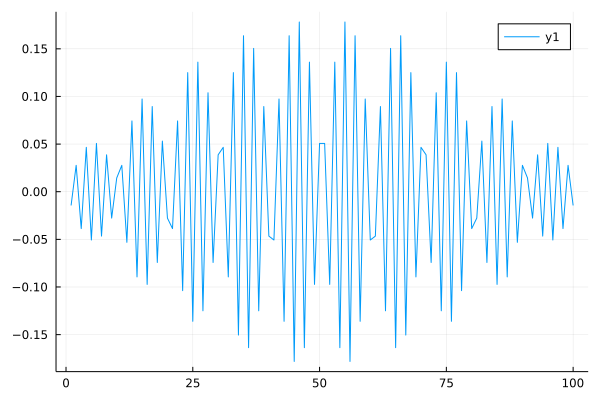

In [56]:
using Plots
plot(Vector(x))

In [ ]:
# doc avec tests sur https://github.com/JuliaAttic/CUSOLVER.jl/blob/master/test/sparse.jl
using CUDA
using SparseArrays
A = Symmetric(rand(10, 10));
A_cuda = CUDA.CUSPARSE.CuSparseMatrixCSR{ComplexF64}(sparse(A))
CUDA.CUSOLVER.heevd!('V','U', A_cuda)

# Brouillon

In [5]:
typeof(CUDA.CUSOLVER.cu(6.5+8.3*im))

ComplexF64 (alias for Complex{Float64})

In [6]:
# générer une matrice creuse sur GPU 
using CUDA
using SparseArrays
A = rand(10,10)
A = CUDA.cu(A)
CUDA.CUSPARSE.CuSparseMatrixCSR(A);

10×10 CUDA.CUSPARSE.CuSparseMatrixCSR{Float32, Int32} with 100 stored entries:
 0.40146056  0.69666183  0.48392725  …  0.55610645   0.70135146  0.4424514
 0.7824187   0.82393533  0.4817871      0.658985     0.36674246  0.35561138
 0.80707985  0.30224553  0.38463345     0.030790616  0.44305095  0.77199596
 0.7900074   0.3170761   0.96026766     0.62705296   0.39838463  0.70616513
 0.72153026  0.4496554   0.94054854     0.5643194    0.35127285  0.3698378
 0.20032066  0.33884728  0.5675699   …  0.46843728   0.6150995   0.5635175
 0.09722471  0.52526915  0.12632577     0.06262363   0.28019646  0.55479527
 0.36497658  0.89222765  0.8376817      0.5722178    0.63692886  0.74420166
 0.64299124  0.67762375  0.754309       0.5833524    0.6662985   0.8861629
 0.7415863   0.9853348   0.8992395      0.22196649   0.40297723  0.37753376

In [ ]:
# x = Symmetric(rand(5,5));
# x = cu(x)
# # x = CUDA.rand(5,5);
# CUDA.CUSOLVER.sytrf!(x)

# LinearAlgebra.LAPACK.sytrf!(M_pro_V) # https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/

In [2]:
using CUDA, LinearAlgebra;
A = CUDA.rand(10,10);
B = CUDA.rand(10);

D, ipiv = CUDA.CUSOLVER.getrf!(A);
X = CUDA.CUSOLVER.getrs!('N', A, ipiv, B)

10-element CuArray{Float32, 1, CUDA.Mem.DeviceBuffer}:
  -0.13119002
  -3.4412055
 -15.038681
   6.3824916
  -0.31861752
  18.327326
   9.898261
   1.0874577
  -2.7439198
  -6.874349

In [17]:
using BenchmarkTools
using CUDA
n = 200;
a = CUDA.rand(n,n)
b = CUDA.rand(n,n)
c = CUDA.rand(n,n)
@benchmark CUDA.@sync muladd(a,b,c) 

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   92.500 μs …  1.669 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):      99.800 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   108.808 μs ± 34.922 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▄███▇▆▆▄▄▃▂▂▂▃▃▂▂▂▂▂▂▁▁▁▁▁▁                                  ▂
  ███████████████████████████████████▇▇▇▇▆▇▆▆▆▆▆▃▆▆▇▅▆▆▆▅▅▅▄▄▅ █
  92.5 μs       Histogram: log(frequency) by time       207 μs <

 Memory estimate: 976 bytes, allocs estimate: 28.

In [18]:
n = 200;
a = rand(n,n)
b = rand(n,n)
c = rand(n,n)
@benchmark muladd($a,$b,$c)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  168.300 μs …   3.916 ms  ┊ GC (min … max): 0.00% … 91.49%
 Time  (median):     197.550 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   227.422 μs ± 119.004 μs  ┊ GC (mean ± σ):  2.89% ±  6.13%

  ▅██▅▃▄▅▅▅▅▄▄▄▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁ ▁                                ▂
  █████████████████████████████████████▇▇▇▇▇▇▇▆▇▆▆▆▄▅▄▆▄▅▃▄▄▃▅▅ █
  168 μs        Histogram: log(frequency) by time        528 μs <

 Memory estimate: 312.55 KiB, allocs estimate: 2.

In [ ]:
N_t = 1000
r = convert(Float32, 5.4)
s = CUDA.rand(N_t,N_t);
t = CUDA.CUSPARSE.CuSparseMatrixCSC(sprand(Float32,N_t,N_t,1/N_t))
CUDA.@time t*s; # s*t non
CUDA.@time s*s;

## Tests librairies graphes

In [ ]:
using DataStructures

In [6]:
using Graphs
using GraphPlot
using Compose
using Cairo, Fontconfig

# g = random_orientation_dag(wheel_graph(10))
g = SimpleDiGraph(4,0, seed=5);
add_vertices!(g, 1) # adds n vertices to g
add_edge!(g, 1, 2) # adds the edge (s, d) to g
g = binary_tree(3)

nodelabel = 1:Graphs.nv(g)
edgelabel = 1:Graphs.ne(g)
draw(PNG("./wheel10.png", 16cm, 16cm), gplot(g, nodelabel=nodelabel, edgelabel=edgelabel, nodelabelsize=10, layout=spectral_layout));


(process:15464): GLib-GIO-WARNING **: 16:31:10.395: Unexpectedly, UWP app `draw.io.draw.ioDiagrams_19.0.3.0_x64__1zh33159kp73c' (AUMId `draw.io.draw.ioDiagrams_1zh33159kp73c!draw.io.draw.ioDiagrams') supports 2 extensions but has no verbs


In [ ]:
# https://juliagraphs.org/Graphs.jl/dev/first_steps/plotting/
using TikzGraphs
using TikzPictures
g = wheel_graph(10); t = plot(g)

save(SVG("wheel10.SVG"), t)

In [16]:
using SimpleWeightedGraphs
h = SimpleWeightedGraph(3)
add_edge!(h,1,2,.5);
h.weights

3×3 SparseArrays.SparseMatrixCSC{Float64, Int64} with 2 stored entries:
  ⋅   0.5   ⋅ 
 0.5   ⋅    ⋅ 
  ⋅    ⋅    ⋅ 

In [24]:
nodelabel = 1:Graphs.nv(h)
edgelabel = [.5] # collect(reshape(h.weights, Graphs.nv(h)^2));
draw(PNG("./wheel10.png", 16cm, 16cm), gplot(h, nodelabel=nodelabel, edgelabel=edgelabel, nodelabelsize=10, layout=spectral_layout));

In [22]:
collect(reshape(h.weights, Graphs.nv(h)^2))

9-element Vector{Float64}:
 0.0
 0.5
 0.0
 0.5
 0.0
 0.0
 0.0
 0.0
 0.0

In [ ]:
SimpleDiGraph{MonNoeud}(Vector([true, false, true, false, false]), 0)